In [18]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch

In [41]:
def parser_logs(path):
    with open(path, "r") as f:
        mrrs = []
        counter = 1
        for line in f.readlines():
            if "test" in line and "MRR" in line:
                terms = line.strip().replace(":", "").split()
                mrr_idx = terms.index("MRR")
                mrr_val = terms[mrr_idx + 1]
                mrrs.append((5 * counter - 1, float(mrr_val)))
                counter += 1
                
    return np.array(mrrs)

def kd_parser_logs(path):
    with open(path, "r") as f:
        global_mrrs, local_mrrs = [], []
        global_counter, local_counter = 1, 1
        for line in f.readlines():
            if "global" in line and "test" in line:
                terms = line.strip().replace(":", "").split()
                mrr_idx = terms.index("MRR")
                mrr_val = terms[mrr_idx + 1]
                global_mrrs.append((5 * global_counter - 1, float(mrr_val)))
                global_counter += 1

            elif "local" in line and "test" in line:
                terms = line.strip().replace(":", "").split()
                mrr_idx = terms.index("MRR")
                mrr_val = terms[mrr_idx + 1]
                local_mrrs.append((5 * local_counter - 1, float(mrr_val)))
                local_counter += 1
                
    return np.array(global_mrrs), np.array(local_mrrs)


def interpolate(mrr0, mrr1):
    if mrr0.shape[0] > mrr1.shape[0]:
        ref_mrr = mrr0
        be_interpolated_mrr = mrr1
    elif mrr0.shape[0] < mrr1.shape[0]:
        ref_mrr = mrr1
        be_interpolated_mrr = mrr0
    else: return mrr0, mrr1

    new_mrr_vals = torch.nn.functional.interpolate(
        torch.from_numpy(be_interpolated_mrr[:, 1]).unsqueeze(0).unsqueeze(0).unsqueeze(0), 
        (1, ref_mrr.shape[0]), mode='bilinear'
    ).squeeze().numpy()

    return np.stack([ref_mrr[:, 0], new_mrr_vals], axis=-1), ref_mrr



In [45]:
atth_path = ["/home/test/lrz/kge/11_29/FB237/AttH_rank32/train.log", "/home/test/lrz/kge/DMutDE/visualization/train_atth.log"]
roth_path = ["/home/test/lrz/kge/11_29/FB237/RotH_rank32/train.log", "/home/test/lrz/kge/DMutDE/visualization/train_roth.log"]
kd_path = ["/home/test/lrz/kge/DMutDE/visualization/train_ensemble.log", "/home/test/lrz/kge/DMutDE/visualization/train_new.log"]
atth_mrrs0 = parser_logs(atth_path[0])
atth_mrrs1 = parser_logs(atth_path[1])
roth_mrrs0 = parser_logs(roth_path[0])
roth_mrrs1 = parser_logs(roth_path[1])
atth_kd_mrrs0, roth_kd_mrrs0 = kd_parser_logs(kd_path[0])
atth_kd_mrrs1, roth_kd_mrrs1 = kd_parser_logs(kd_path[1])

atth_mrrs0, atth_mrrs1 = interpolate(atth_mrrs0, atth_mrrs1)
roth_mrrs0, roth_mrrs1 = interpolate(roth_mrrs0, roth_mrrs1)
atth_kd_mrrs0, atth_kd_mrrs1 = interpolate(atth_kd_mrrs0, atth_kd_mrrs1)
roth_kd_mrrs0, roth_kd_mrrs1 = interpolate(roth_kd_mrrs0, roth_kd_mrrs1)

atth_mrrs_mean, atth_mrrs_std = np.stack([atth_mrrs0[:, 1], atth_mrrs1[:, 1]], axis=-1).mean(-1), np.stack([atth_mrrs0[:, 1], atth_mrrs1[:, 1]], axis=-1).std(-1)
roth_mrrs_mean, roth_mrrs_std = np.stack([roth_mrrs0[:, 1], roth_mrrs1[:, 1]], axis=-1).mean(-1), np.stack([roth_mrrs0[:, 1], roth_mrrs1[:, 1]], axis=-1).std(-1)
atth_kd_mrrs_mean, atth_kd_mrrs_std = np.stack([atth_kd_mrrs0[:, 1], atth_kd_mrrs1[:, 1]], axis=-1).mean(-1), np.stack([atth_kd_mrrs0[:, 1], atth_kd_mrrs1[:, 1]], axis=-1).std(-1)
roth_kd_mrrs_mean, roth_kd_mrrs_std = np.stack([roth_kd_mrrs0[:, 1], roth_kd_mrrs1[:, 1]], axis=-1).mean(-1), np.stack([roth_kd_mrrs0[:, 1], roth_kd_mrrs1[:, 1]], axis=-1).std(-1)



In [46]:
atth_mrrs_mean

array([0.2635    , 0.27820213, 0.28632447, 0.29215426, 0.29620745,
       0.29942021, 0.30201064, 0.30378191, 0.30537234, 0.30659043,
       0.30749468, 0.30879787, 0.31      , 0.31020745, 0.3111117 ,
       0.31201596, 0.31292021, 0.313     , 0.31322872, 0.314     ,
       0.31403723, 0.31494149, 0.315     , 0.31475   , 0.3155    ,
       0.3155    , 0.3155    , 0.3155    , 0.31577128, 0.3165    ,
       0.3165    , 0.3165    , 0.3168883 , 0.31670745, 0.31669681,
       0.3175    , 0.317     , 0.317     , 0.317     , 0.31678191,
       0.3165    , 0.3165266 , 0.31693085, 0.31666489, 0.3165    ,
       0.31664362, 0.3175    ])

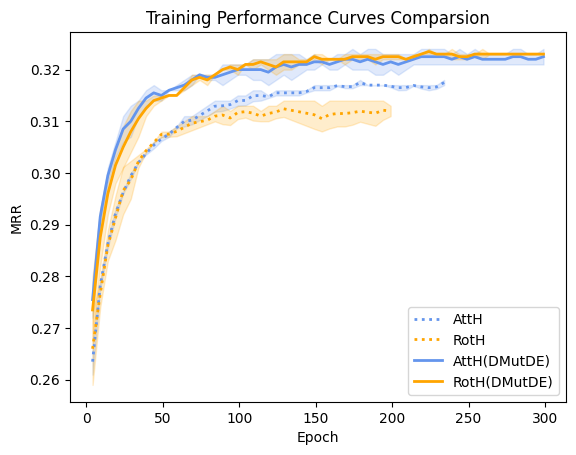

In [54]:
fig = plt.figure()
ax = plt.axes()
linewidth = 2


plt.title("Training Performance Curves Comparsion")
ax.set_xlabel("Epoch")
ax.set_ylabel("MRR")
ax.plot(atth_mrrs0[:, 0], atth_mrrs_mean, color="cornflowerblue", linestyle=":", label="AttH", linewidth=linewidth)
plt.fill_between(atth_mrrs0[:, 0], atth_mrrs_mean-atth_mrrs_std,  atth_mrrs_mean+atth_mrrs_std, color="cornflowerblue", alpha=0.2)
ax.plot(roth_mrrs0[:, 0], roth_mrrs_mean, color="orange", linestyle=":", label="RotH", linewidth=linewidth)
plt.fill_between(roth_mrrs0[:, 0], roth_mrrs_mean-roth_mrrs_std,  roth_mrrs_mean+roth_mrrs_std, color="orange", alpha=0.2)
ax.plot(atth_kd_mrrs0[atth_kd_mrrs0[:, 0] < 300, 0], atth_kd_mrrs_mean[atth_kd_mrrs0[:, 0] < 300], color="cornflowerblue", label="AttH(DMutDE)", linewidth=linewidth)
plt.fill_between(atth_kd_mrrs0[atth_kd_mrrs0[:, 0] < 300, 0], atth_kd_mrrs_mean[atth_kd_mrrs0[:, 0] < 300]-atth_kd_mrrs_std[atth_kd_mrrs0[:, 0] < 300],  atth_kd_mrrs_mean[atth_kd_mrrs0[:, 0] < 300]+atth_kd_mrrs_std[atth_kd_mrrs0[:, 0] < 300], color="cornflowerblue", alpha=0.2)
ax.plot(roth_kd_mrrs0[roth_kd_mrrs0[:, 0] < 300, 0], roth_kd_mrrs_mean[roth_kd_mrrs0[:, 0] < 300], color="orange", label="RotH(DMutDE)", linewidth=linewidth)
plt.fill_between(roth_kd_mrrs0[roth_kd_mrrs0[:, 0] < 300, 0], roth_kd_mrrs_mean[roth_kd_mrrs0[:, 0] < 300]-roth_kd_mrrs_std[roth_kd_mrrs0[:, 0] < 300],  roth_kd_mrrs_mean[roth_kd_mrrs0[:, 0] < 300]+roth_kd_mrrs_std[roth_kd_mrrs0[:, 0] < 300], color="orange", alpha=0.2)
plt.legend()
plt.savefig("curvs_std.pdf")


In [42]:
atth_kd_mrrs[atth_kd_mrrs[:, 0] < 300, 0]

array([  4.,   9.,  14.,  19.,  24.,  29.,  34.,  39.,  44.,  49.,  54.,
        59.,  64.,  69.,  74.,  79.,  84.,  89.,  94.,  99., 104., 109.,
       114., 119., 124., 129., 134., 139., 144., 149., 154., 159., 164.,
       169., 174., 179., 184., 189., 194., 199., 204., 209., 214., 219.,
       224., 229., 234., 239., 244., 249., 254., 259., 264., 269., 274.,
       279., 284., 289., 294., 299.])